# Hands On SARSA and Q-learning

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Grid World

### Environment setup (Grid World)

In [25]:
GRID_SIZE = 5
GOAL_STATE = (4, 4)
ACTIONS = ["up", "down", "left", "right"]
NUM_ACTIONS = len(ACTIONS)

### Hyperparameters 

In [26]:
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.1
EPISODES = 1000

### Transition Function 

In [27]:
def step(state, action):
    x, y = state
    if action == "up" and x > 0:
        x -= 1
    elif action == "down" and x < GRID_SIZE - 1:
        x += 1
    elif action == "left" and y > 0:
        y -= 1
    elif action == "right" and y < GRID_SIZE - 1:
        y += 1
    new_state = (x, y)
    reward = 10 if new_state == GOAL_STATE else -1
    done = new_state == GOAL_STATE
    return new_state, reward, done

### Policy

In [28]:
def choose_action(state, q_table):
    if random.uniform(0, 1) < EPSILON:
        return random.choice(ACTIONS)
    else:
        state_idx = state[0] * GRID_SIZE + state[1]
        return ACTIONS[np.argmax(q_table[state_idx])]

### SARSA

In [29]:
def sarsa():
    q_table = np.zeros((GRID_SIZE * GRID_SIZE, NUM_ACTIONS))
    rewards = []
    for episode in range(EPISODES):
        state = (0, 0)
        action = choose_action(state, q_table)
        total_reward = 0
        while True:
            next_state, reward, done = step(state, action)
            next_action = choose_action(next_state, q_table)
            state_idx = state[0] * GRID_SIZE + state[1]
            next_state_idx = next_state[0] * GRID_SIZE + next_state[1]
            action_idx = ACTIONS.index(action)
            next_action_idx = ACTIONS.index(next_action)
            q_table[state_idx, action_idx] += ALPHA * (
                reward + GAMMA * q_table[next_state_idx, next_action_idx] - q_table[state_idx, action_idx]
            )
            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return q_table, rewards

### Q-Learning

In [30]:
def q_learning():
    q_table = np.zeros((GRID_SIZE * GRID_SIZE, NUM_ACTIONS))
    rewards = []
    for episode in range(EPISODES):
        state = (0, 0)
        total_reward = 0
        while True:
            action = choose_action(state, q_table)
            next_state, reward, done = step(state, action)
            state_idx = state[0] * GRID_SIZE + state[1]
            next_state_idx = next_state[0] * GRID_SIZE + next_state[1]
            action_idx = ACTIONS.index(action)
            q_table[state_idx, action_idx] += ALPHA * (
                reward + GAMMA * np.max(q_table[next_state_idx]) - q_table[state_idx, action_idx]
            )
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return q_table, rewards

### Runing Algorithms

In [31]:
print("SARSA...")
q_table_sarsa, rewards_sarsa = sarsa()
print("Q-Learning...")
q_table_q, rewards_q = q_learning()

SARSA...
Q-Learning...


### Learning Plots

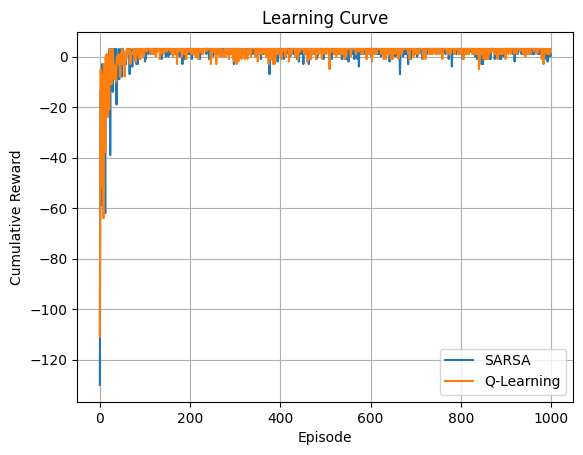

In [32]:
plt.plot(rewards_sarsa, label="SARSA")
plt.plot(rewards_q, label="Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

### Testing the Optimal Path

In [33]:
def print_optimal_path(q_table):
    state = (0, 0)
    path = [state]
    while state != GOAL_STATE:
        state_idx = state[0] * GRID_SIZE + state[1]
        action = ACTIONS[np.argmax(q_table[state_idx])]
        state, _, done = step(state, action)
        path.append(state)
        if done:
            break
    print("Optimal Path:", path)

print("\n SARSA Optimal Path :")
print_optimal_path(q_table_sarsa)
print("\n Q-Learning Optimal Path:")
print_optimal_path(q_table_q)


 SARSA Optimal Path :
Optimal Path: [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4)]

 Q-Learning Optimal Path:
Optimal Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 4)]


## Taxi-v3

In [34]:
import gym

### Hyperparameters

In [35]:
GAMMA = 0.9
EPSILON = 0.1
EPISODES = 5000

### Environment setup

In [36]:
env = gym.make("Taxi-v3")
NUM_STATES = env.observation_space.n
NUM_ACTIONS = env.action_space.n

### Policy (epsilon-greedy)

In [37]:
def choose_action(state, q_table):
    if random.uniform(0, 1) < EPSILON:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

### SARSA

In [38]:
def sarsa(alpha):
    q_table = np.zeros((NUM_STATES, NUM_ACTIONS))
    for episode in range(EPISODES):
        state, _ = env.reset()
        action = choose_action(state, q_table)
        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = choose_action(next_state, q_table)
            q_table[state, action] += alpha * (
                reward + GAMMA * q_table[next_state, next_action] - q_table[state, action]
            )
            state = next_state
            action = next_action
            if done:
                break
    return q_table

### Q-Learning

In [39]:
def q_learning(alpha):
    q_table = np.zeros((NUM_STATES, NUM_ACTIONS))
    for episode in range(EPISODES):
        state, _ = env.reset()
        while True:
            action = choose_action(state, q_table)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            q_table[state, action] += alpha * (
                reward + GAMMA * np.max(q_table[next_state]) - q_table[state, action]
            )
            state = next_state
            if done:
                break
    return q_table

### Reward Evaluation

In [40]:
def evaluate(q_table, episodes=100):
    total_reward = 0
    for _ in range(episodes):
        state, _ = env.reset()
        while True:
            action = np.argmax(q_table[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            if done:
                break
    return total_reward / episodes

### Runing Algos

In [41]:
alpha_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
sarsa_rewards = []
q_learning_rewards = []

In [42]:
for alpha in alpha_values:
    print(f"Running SARSA with alpha={alpha}...")
    q_sarsa = sarsa(alpha)
    avg_reward_sarsa = evaluate(q_sarsa)
    sarsa_rewards.append(avg_reward_sarsa)

    print(f"Running Q-Learning with alpha={alpha}...")
    q_qlearn = q_learning(alpha)
    avg_reward_qlearn = evaluate(q_qlearn)
    q_learning_rewards.append(avg_reward_qlearn)

Running SARSA with alpha=0.01...


c:\Users\Aliak\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running Q-Learning with alpha=0.01...
Running SARSA with alpha=0.05...
Running Q-Learning with alpha=0.05...
Running SARSA with alpha=0.1...
Running Q-Learning with alpha=0.1...
Running SARSA with alpha=0.3...
Running Q-Learning with alpha=0.3...
Running SARSA with alpha=0.5...
Running Q-Learning with alpha=0.5...
Running SARSA with alpha=0.7...
Running Q-Learning with alpha=0.7...
Running SARSA with alpha=0.9...
Running Q-Learning with alpha=0.9...


### Plots

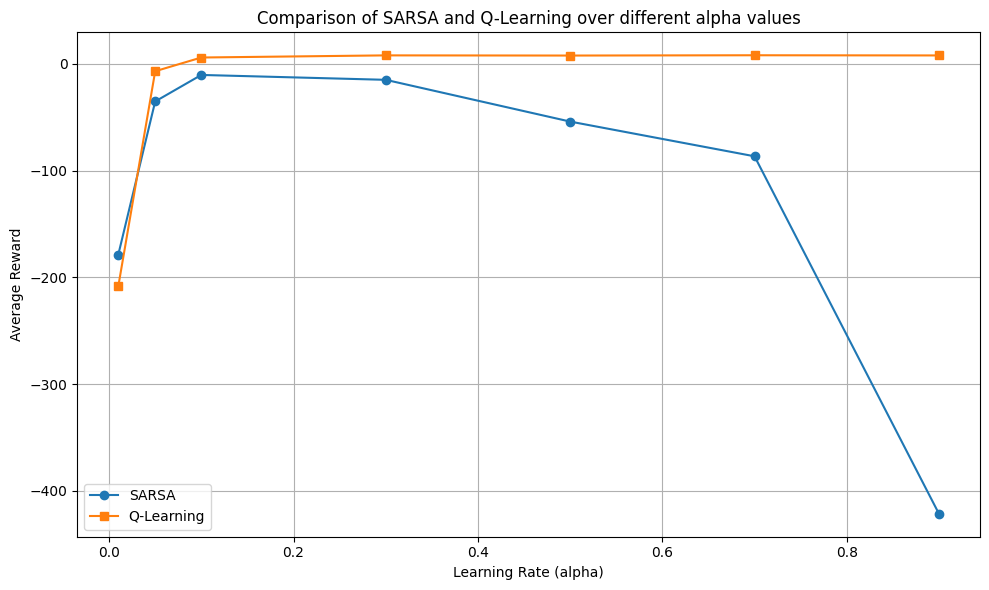

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, sarsa_rewards, marker='o', label='SARSA')
plt.plot(alpha_values, q_learning_rewards, marker='s', label='Q-Learning')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Average Reward')
plt.title('Comparison of SARSA and Q-Learning over different alpha values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()